In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

current_folder = os.getcwd()
print(current_folder)

from parse.loadCsvSignal import loadCsvSignal
from parse.loadParquetSample import loadParquetSample
from parse.loadCsvSample import loadCsvSample

from plot.plotSegments import plotSegments

from signalProcessing.computeSlotsAverage import computeSlotsAverage
from signalProcessing.splitSignal import splitSignal
from signalProcessing.removeSegmentsBeginning import removeSegmentsBeginning

from temperatureCorrection.getTemperatureCorrectionData import getTemperatureCorrectionData
from temperatureCorrection.findTemperatureOffset import findTemperatureOffset
from temperatureCorrection.showTempCorrectionPlots import showTempCorrectionPlots
from temperatureCorrection.correctSpindleCurrent import correctSpindleCurrent

from utils.detectConstantSegments import detectConstantSegments
from utils.getOperationsStart import getOperationsStart
from utils.customPolyFit import getPolyRegression, evalPolyReg
from utils.polyFit import getPolyFits, getRelativeErrors, evalModels

current_folder = current_folder.split("\\src")[0]
print(current_folder)


c:\Users\Antoine\Documents\master\PI\predictiveMaintenance-main\src\notebooks
c:\Users\Antoine\Documents\master\PI\predictiveMaintenance-main


In [2]:
#get warm up data info
def getWupInfo(data_path) :
    machine_folds = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

    warm_up_info = []

    for machine_fold in machine_folds :
        machine_path = os.path.join(data_path, machine_fold)
        for warm_up in os.listdir(machine_path) :
            dict = {}
            dict["machine_name"] = machine_fold.split("_")[-1]
            dict["warm_up_name"] = warm_up.split(".parquet")[0 ] if warm_up.endswith(".parquet") else warm_up
            dict["warm_up_type"] = "parquet" if warm_up.endswith(".parquet") else "csv_folder"
            dict["warm_up_path"] = os.path.join(machine_path, warm_up)

            warm_up_info.append(dict)
    
    return warm_up_info

raw_path = os.path.join(current_folder, "data", "raw")

raw_data_info = getWupInfo(raw_path)

for i in raw_data_info :
    print(i)


{'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_03_02_25', 'warm_up_type': 'csv_folder', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\raw\\Machine_#1_Mecatis\\Warmup_Mecatis_03_02_25'}
{'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_05_02_25', 'warm_up_type': 'csv_folder', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\raw\\Machine_#1_Mecatis\\Warmup_Mecatis_05_02_25'}
{'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_10_03_25', 'warm_up_type': 'csv_folder', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\raw\\Machine_#1_Mecatis\\Warmup_Mecatis_10_03_25'}
{'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_10_03_25_3', 'warm_up_type': 'csv_folder', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\raw\\Machine_#1_Mecatis\\Warmup_Mecatis_10_03_25_3'}
{'machine_na

In [58]:
#prepare warm up data
prepared_path = os.path.join(current_folder,"data" ,"prepared")

def prepareWupData(warm_up_info, prepared_path) :
    for warm_up_dict in warm_up_info :
        if warm_up_dict["warm_up_type"] == "parquet" :
            df = loadParquetSample(warm_up_dict["warm_up_path"])

        elif warm_up_dict["warm_up_type"] == "csv_folder" :
            df = loadCsvSample(warm_up_dict["warm_up_path"])
        
        print(f"{warm_up_dict["warm_up_name"]} loaded")

        save_path = os.path.join(prepared_path, warm_up_dict["machine_name"])
        os.makedirs(save_path, exist_ok=True)
        df.to_parquet(os.path.join(save_path, warm_up_dict['warm_up_name']+".parquet"))
        
        print(f"{warm_up_dict["warm_up_name"]} prepared")

prepareWupData(raw_data_info, prepared_path)    

KeyboardInterrupt: 

In [3]:
prepared_path = os.path.join(current_folder,"data" ,"prepared")
prepared_data_info = getWupInfo(prepared_path)
print(prepared_data_info)

[{'machine_name': 'Locle', 'warm_up_name': '2025_03_18_Heating_Cycle_MecatisLL', 'warm_up_type': 'parquet', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\prepared\\Locle\\2025_03_18_Heating_Cycle_MecatisLL.parquet'}, {'machine_name': 'Locle', 'warm_up_name': '2025_03_20_Warmup_V5_LL', 'warm_up_type': 'parquet', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\prepared\\Locle\\2025_03_20_Warmup_V5_LL.parquet'}, {'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_03_02_25', 'warm_up_type': 'parquet', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\prepared\\Mecatis\\Warmup_Mecatis_03_02_25.parquet'}, {'machine_name': 'Mecatis', 'warm_up_name': 'Warmup_Mecatis_05_02_25', 'warm_up_type': 'parquet', 'warm_up_path': 'c:\\Users\\Antoine\\Documents\\master\\PI\\predictiveMaintenance-main\\data\\prepared\\Mecatis\\Warmup_Mecatis_05_02_25.parquet'}, {

In [4]:
def loadPreparedData(data_info) :
    for warm_up_dict in data_info :
        warm_up_dict["data"] = pd.read_parquet(warm_up_dict["warm_up_path"])
        #Rename la colonne time pour les parquet
        if warm_up_dict["warm_up_type"] == "parquet":
            warm_up_dict["data"].rename(columns={"time": "timeSeconds"}, inplace=True)
        
        print(f"{warm_up_dict["warm_up_name"]} loaded")

    return data_info

data_prepared = loadPreparedData(prepared_data_info)

2025_03_18_Heating_Cycle_MecatisLL loaded
2025_03_20_Warmup_V5_LL loaded
Warmup_Mecatis_03_02_25 loaded
Warmup_Mecatis_05_02_25 loaded
Warmup_Mecatis_10_03_25 loaded
Warmup_Mecatis_10_03_25_3 loaded
Warmup_Mecatis_10_03_25_4 loaded
Warmup_Mecatis_10_03_25_5 loaded
Warmup_V5_Mecatis_240325 loaded
13-03-2025_10h35 loaded
13-03-2025_7h35 loaded
19-02-2025_9h20 loaded


In [5]:
print(len(data_prepared))

for warm_up_dict in data_prepared :
    print(warm_up_dict["warm_up_name"])
    if "stSigAxCurrentX" in warm_up_dict["data"].columns :

        print("exist")
    else :
        print("no exist")


12
2025_03_18_Heating_Cycle_MecatisLL
no exist
2025_03_20_Warmup_V5_LL
no exist
Warmup_Mecatis_03_02_25
exist
Warmup_Mecatis_05_02_25
exist
Warmup_Mecatis_10_03_25
exist
Warmup_Mecatis_10_03_25_3
exist
Warmup_Mecatis_10_03_25_4
exist
Warmup_Mecatis_10_03_25_5
exist
Warmup_V5_Mecatis_240325
exist
13-03-2025_10h35
exist
13-03-2025_7h35
exist
19-02-2025_9h20
exist


In [6]:
import colorsys

category_to_hue_range = {
    "Mecatis": (0.55, 0.65),    # bleu
    "MILL": (0.0, 0.05),    # rouge
    "Locle": (0.25, 0.35)  # vert
}

def random_color_from_category(category ,seed):
    """Retourne une couleur RGB aléatoire associée à une catégorie."""
    np.random.seed(seed)
    if category not in category_to_hue_range:
        raise ValueError(f"Catégorie inconnue : {category}")
    
    hue_min, hue_max = category_to_hue_range[category]
    hue = np.random.uniform(hue_min, hue_max, )
    sat = np.random.uniform(0.5, 1.0)
    val = np.random.uniform(0.6, 1.0)
    return colorsys.hsv_to_rgb(hue, sat, val)

seeds = np.arange(0,len(data_prepared),1)
#set colors
for seed, warm_up_dict in zip(seeds, data_prepared) :
    warm_up_dict["color"]=random_color_from_category(warm_up_dict["machine_name"], seed)


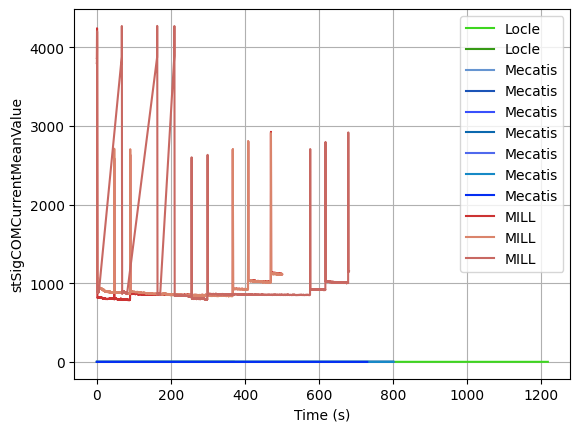

In [88]:


def plot_signal(data, signal_name, max_time_index, time_offset=0):
    for warm_up_dict in data :
        if signal_name in warm_up_dict["data"].columns :
            time = warm_up_dict["data"].loc[time_offset:max_time_index+time_offset, "timeSeconds"]
            signal = warm_up_dict["data"].loc[time_offset:max_time_index+time_offset, signal_name]
            plt.plot(time, signal, color = warm_up_dict["color"], markersize=3)
            plt.xlabel("Time (s)")
            plt.ylabel(signal_name)

    legend = [warm_up_dict["machine_name"] if signal_name in warm_up_dict["data"].columns else None for warm_up_dict in data]
    legend = [x for x in legend if x is not None]
    plt.legend(legend,loc='upper right')
    plt.grid()
    plt.show()

signal_name = "stSigCOMCurrentMeanValue"
max_time_index = 1000000

plot_signal(data_prepared, signal_name, max_time_index, time_offset=0)

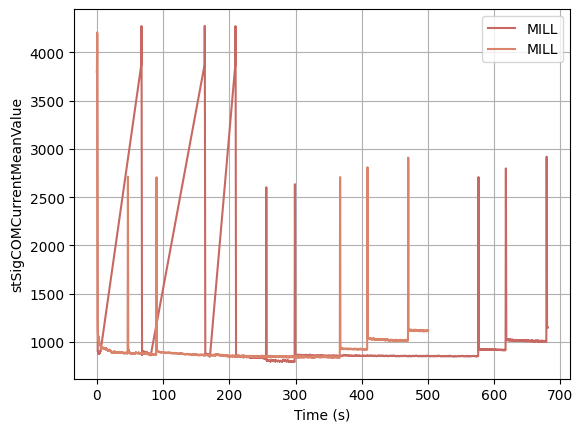

In [89]:
filtered_data = [data_prepared[-1]] + [data_prepared[-2]] 

plot_signal(filtered_data, "stSigCOMCurrentMeanValue", max_time_index, time_offset=0)

In [90]:
print(filtered_data[0]["data"].columns)

Index(['timeSeconds', 'stSigAxCurrentB', 'stSigAxCurrentC', 'stSigAxCurrentX',
       'stSigAxCurrentY', 'stSigAxCurrentZ', 'stSigAxFollErrB',
       'stSigAxFollErrC', 'stSigAxFollErrX', 'stSigAxFollErrY',
       'stSigAxFollErrZ', 'stSigAxPosACSB', 'stSigAxPosACSC', 'stSigAxPosACSX',
       'stSigAxPosACSY', 'stSigAxPosACSZ', 'stSigAxPosMCSB', 'stSigAxPosMCSC',
       'stSigAxPosMCSX', 'stSigAxPosMCSY', 'stSigAxPosMCSZ', 'stSigAxVeloACSB',
       'stSigAxVeloACSC', 'stSigAxVeloACSX', 'stSigAxVeloACSY',
       'stSigAxVeloACSZ', 'stSigAxVeloMCSB', 'stSigAxVeloMCSC',
       'stSigAxVeloMCSX', 'stSigAxVeloMCSY', 'stSigAxVeloMCSZ',
       'stSigCOMCurrentMeanValue', 'stSigCOMThresholdTrigger', 'stSigSinus',
       'stSigSpindleIndicator', 'stSigStatusULInt', 'stSigTouchPosACSB',
       'stSigTouchPosACSC', 'stSigTouchPosACSX', 'stSigTouchPosACSY',
       'stSigTouchPosACSZ', 'stSigTouchPosMCSB', 'stSigTouchPosMCSC',
       'stSigTouchPosMCSY', 'stSigTouchPosMCSZ', 'stSigOperation',
     

In [91]:
for ind in range(max_time_index) :
    time1 = data_prepared[0]["data"]["timeSeconds"][ind]
    time2 = data_prepared[1]["data"]["timeSeconds"][ind]

    if time1 != time2 :
        print(f"index, {ind}")
        print(time1)
        print(time2)
        
        break


index, 617
0.618
0.617


Text(0.5, 1.0, 'Signals on same sampling interval')

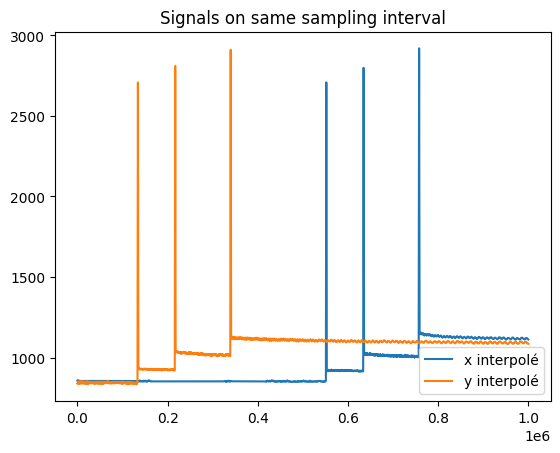

In [92]:
from scipy.interpolate import interp1d

#interpolate signals on the same time scale
max_time_index = 1000000
offset = 600000

signal1 = filtered_data[0]["data"].loc[offset:max_time_index+offset, "stSigCOMCurrentMeanValue"]
signal2 = filtered_data[1]["data"].loc[offset:max_time_index+offset, "stSigCOMCurrentMeanValue"]



t1 = filtered_data[0]["data"].loc[:max_time_index, "timeSeconds"]
t2 = filtered_data[1]["data"].loc[:max_time_index, "timeSeconds"]

def interpOnSameTimeScale(signal1, signal2, t1, t2, point_count=1000000):
    # create commun time scale
    t_common = np.linspace(max(t1.iloc[0], t2.iloc[0]), min(t1.iloc[-1], t2.iloc[-1]), point_count)

    # interpolate on t_common
    x_interp = interp1d(t1, signal1, kind='linear')(t_common)
    y_interp = interp1d(t2, signal2, kind='linear')(t_common)

    return x_interp, y_interp, t_common

x_interp, y_interp, _ = interpOnSameTimeScale(signal1, signal2, t1, t2)


plt.plot(x_interp, label='x interpolé')
plt.plot(y_interp, label='y interpolé')
plt.legend()
plt.title("Signals on same sampling interval")



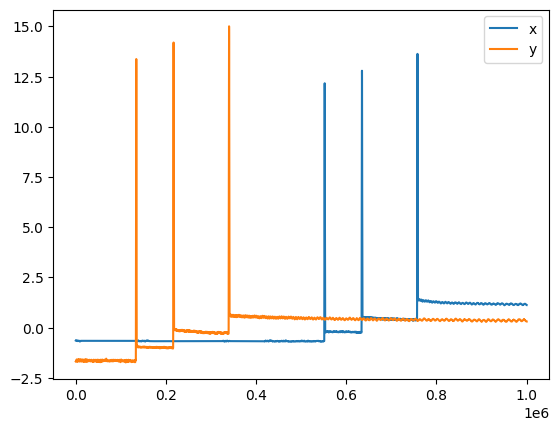

In [93]:
def normSignal(signal):
    signal_c = signal - np.mean(signal)
    signal_n = signal_c / np.std(signal_c)

    return signal_n

x_norm = normSignal(x_interp)
y_norm = normSignal(y_interp)

plt.plot(x_norm, label='x')
plt.plot(y_norm, label='y')
plt.legend()

In [94]:
from scipy.signal import correlate

def getLag(signal1_n, n_signal2_n):
    correlation = correlate(n_signal2_n, signal1_n, mode='full')
    lags = np.arange(-len(signal1_n) + 1, len(n_signal2_n))
    lag_max = lags[np.argmax(correlation)]

    return lag_max

lag = getLag(x_norm, y_norm)
print(lag)

-417834


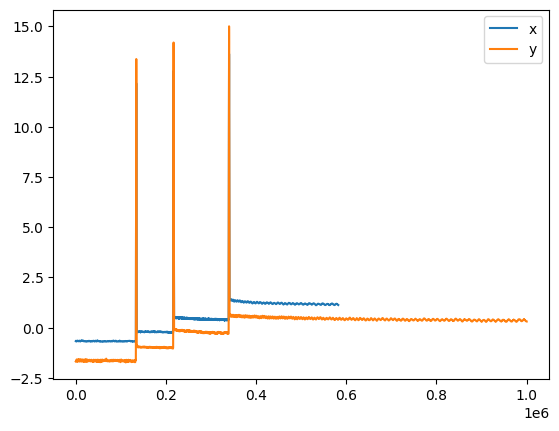

In [95]:

x_lag = x_norm[np.abs(lag):]
y_lag = y_norm

plt.plot(x_lag, label='x')
plt.plot(y_lag, label='y')
plt.legend()

Mean error before : 0.7573126413473581
Mean error after : 0.10711496160383951


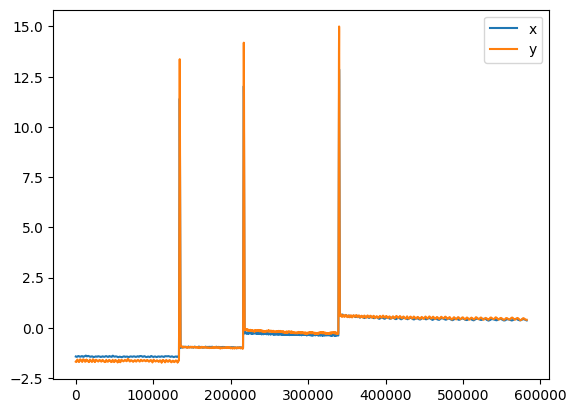

In [96]:
y_aligned = y_lag[:x_lag.shape[0]]

delta_before = np.mean(x_lag - y_aligned)

x_aligned = x_lag-delta_before

delta_after = np.mean(np.abs(x_aligned - y_aligned))

plt.plot(x_aligned, label='x')
plt.plot(y_aligned, label='y')
plt.legend()


print(f"Mean error before : {delta_before}")
print(f"Mean error after : {delta_after}")

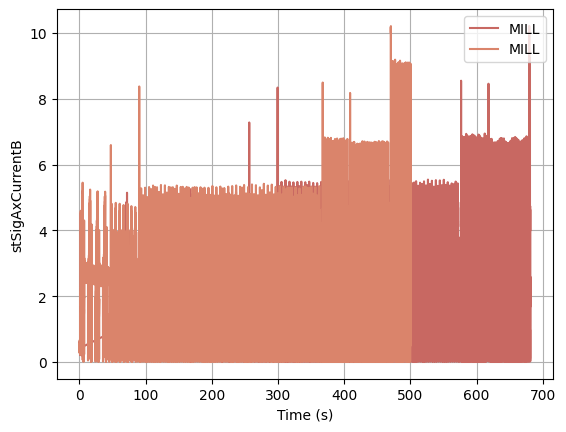

In [83]:
plot_signal(filtered_data, "stSigAxCurrentB", max_time_index, time_offset=0)


Text(0.5, 1.0, 'Signals on same sampling interval')

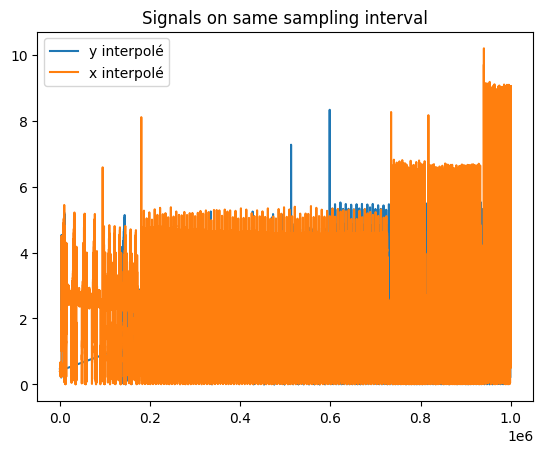

In [84]:
max_time_index = 1000000
offset = 0

signal1 = filtered_data[0]["data"].loc[offset:max_time_index+offset, "stSigAxCurrentB"]
signal2 = filtered_data[1]["data"].loc[offset:max_time_index+offset, "stSigAxCurrentB"]



t1 = filtered_data[0]["data"].loc[:max_time_index, "timeSeconds"]
t2 = filtered_data[1]["data"].loc[:max_time_index, "timeSeconds"]

x_interp, y_interp, _ = interpOnSameTimeScale(signal1, signal2, t1, t2)

plt.plot(x_interp, label='y interpolé')
plt.plot(y_interp, label='x interpolé')

plt.legend()
plt.title("Signals on same sampling interval")



In [85]:
print(lag)

-417834


Mean error before : 0.2889115212899354
Mean error after : 1.2351618758038452e-17


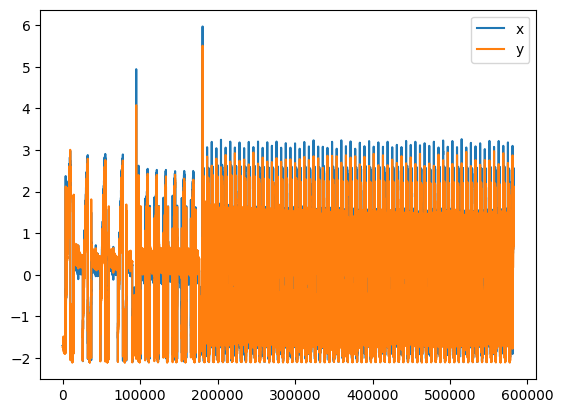

In [ ]:
x_norm = normSignal(x_interp)
y_norm = normSignal(y_interp)

x_lag = x_norm[np.abs(lag):]
y_lag = y_norm

y_aligned = y_lag[:x_lag.shape[0]]

delta_before = np.mean(x_lag - y_aligned)

x_aligned = x_lag-delta_before

delta_after = np.mean(np.abs(x_aligned - y_aligned))

plt.plot(x_aligned, label='x')
plt.plot(y_aligned, label='y')
plt.legend()

print(f"Mean error before : {delta_before}")
print(f"Mean error after : {delta_after}")

In [19]:
print(signal1)
print(signal2)

0          3799.984769
1          3799.984335
2          3799.984407
3          3799.984479
4          3799.985059
              ...     
999996     1151.629789
999997     1151.639538
999998     1151.650285
999999     1151.661032
1000000    1151.673475
Name: stSigCOMCurrentMeanValue, Length: 1000001, dtype: float64
0          3799.973022
1          3799.975627
2          3799.976495
3          3799.974614
4          3799.977291
              ...     
999996     1117.079735
999997     1117.079735
999998     1117.097647
999999     1117.108571
1000000    1117.118739
Name: stSigCOMCurrentMeanValue, Length: 1000001, dtype: float64


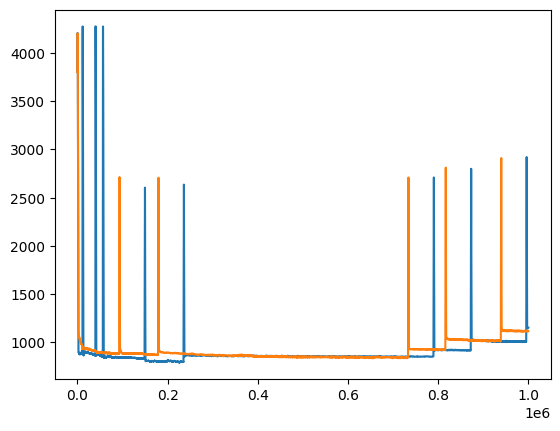

In [14]:
plt.plot(signal1)
plt.plot(signal2)
plt.show()

In [77]:
index = 2
signals = data_prepared[2]["data"].columns

print(data_prepared[index]["warm_up_name"])
print(signals)

Warmup_Mecatis_03_02_25
Index(['timeSeconds', 'stSigAxCurrentB', 'diCodeMesure', 'lrSigAxeBTemp',
       'lrSigAxeCTemp', 'lrSigAxeXTemp', 'lrSigAxeYTemp', 'lrSigAxeZTemp',
       'lrSigCryoLubState', 'lrSigFeedRateOverride', 'lrSigLubrificationState',
       'lrSigMeasurementMode', 'lrSigPieceTemp', 'lrSigSpindleOverride',
       'lrSigSpindleTemp', 'lrSigTableTemp', 'lrSigZoneAxeTemp',
       'm70DataDouble', 'process', 'stSigAxCurrentC', 'stSigAxCurrentS',
       'stSigAxCurrentX', 'stSigAxCurrentY', 'stSigAxCurrentZ',
       'stSigAxFollErrB', 'stSigAxFollErrC', 'stSigAxFollErrX',
       'stSigAxFollErrY', 'stSigAxFollErrZ', 'stSigAxPosACSB',
       'stSigAxPosACSC', 'stSigAxPosACSX', 'stSigAxPosACSY', 'stSigAxPosACSZ',
       'stSigAxPosMCSB', 'stSigAxPosMCSC', 'stSigAxPosMCSX', 'stSigAxPosMCSY',
       'stSigAxPosMCSZ', 'stSigAxVeloACSB', 'stSigAxVeloACSC',
       'stSigAxVeloACSX', 'stSigAxVeloACSY', 'stSigAxVeloACSZ',
       'stSigAxVeloMCSB', 'stSigAxVeloMCSC', 'stSigAxVeloMCS

In [79]:
print(data_prepared[1]["warm_up_name"])
print(data_prepared[8]["warm_up_name"])

2025_03_20_Warmup_V5_LL
Warmup_V5_Mecatis_240325


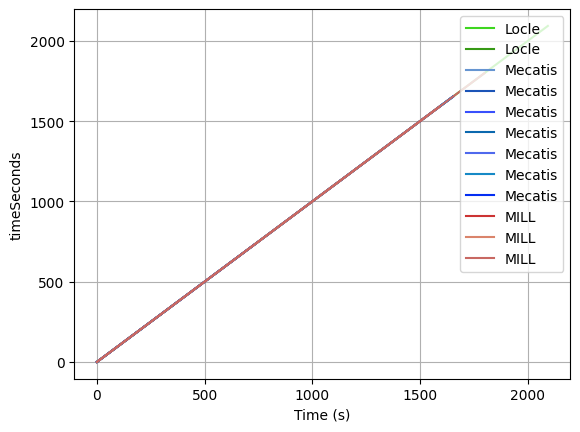

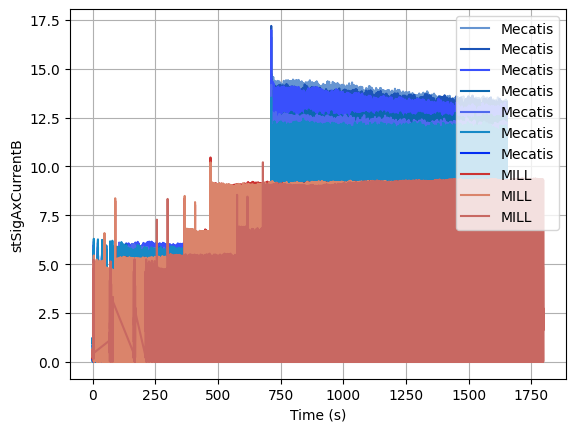

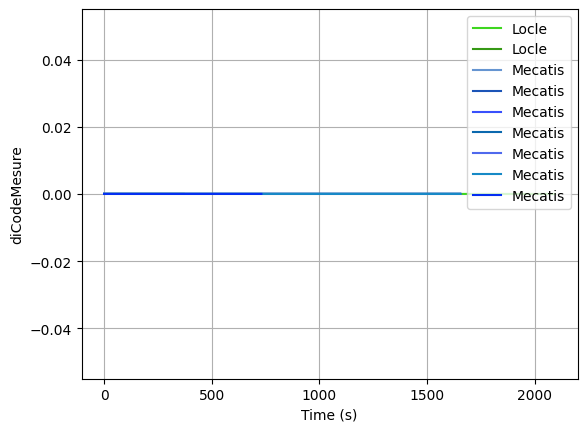

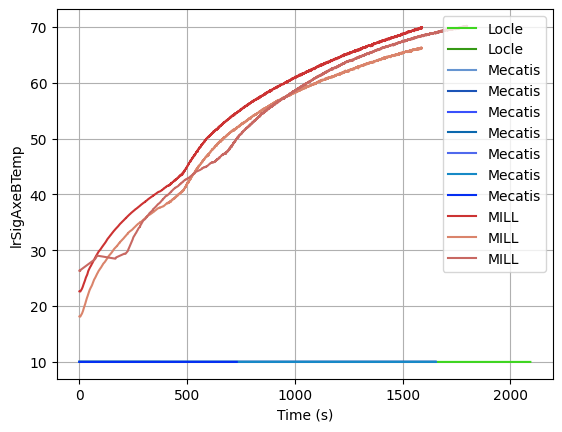

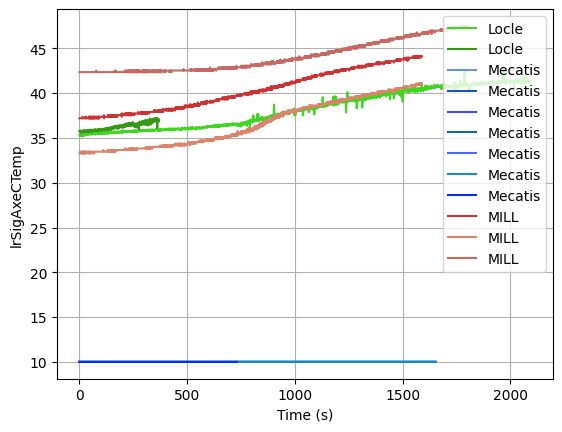

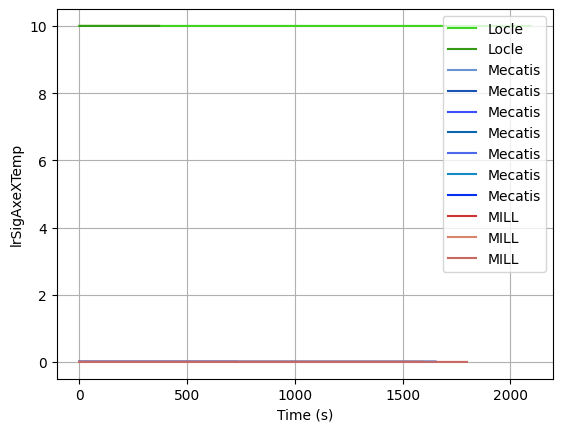

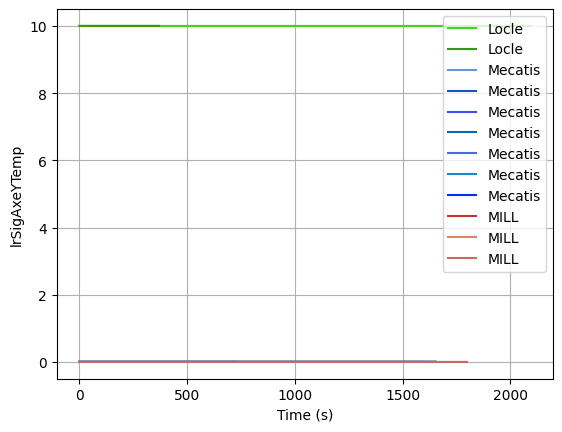

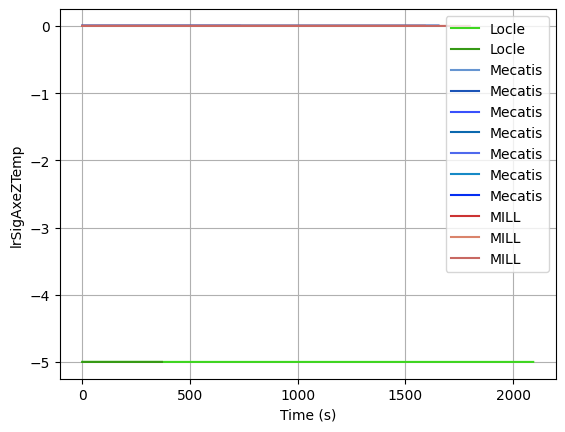

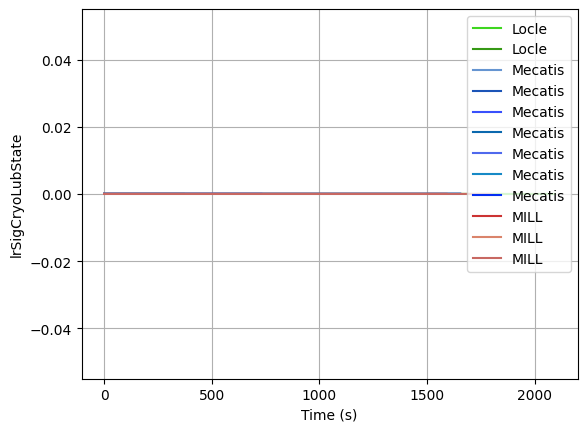

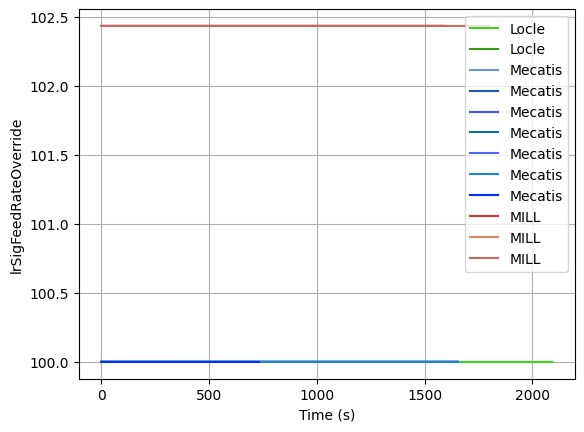

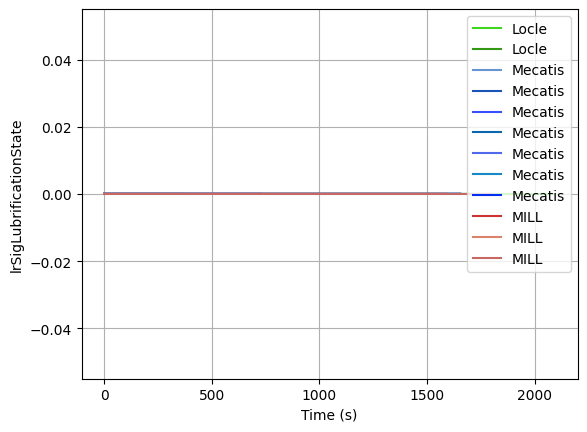

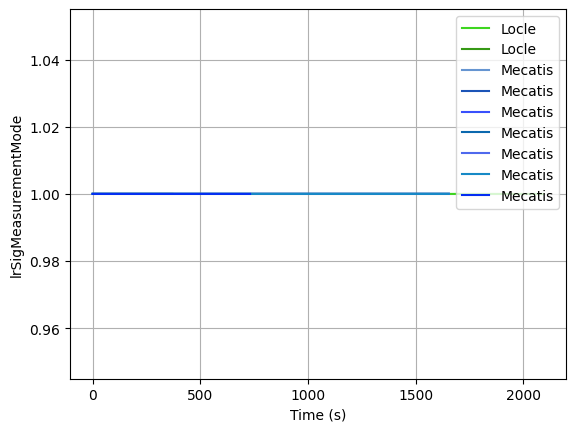

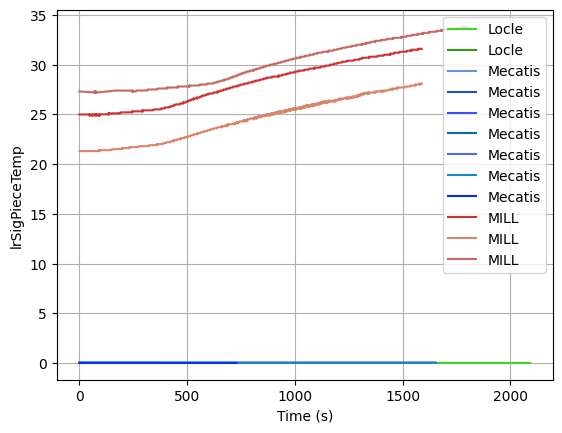

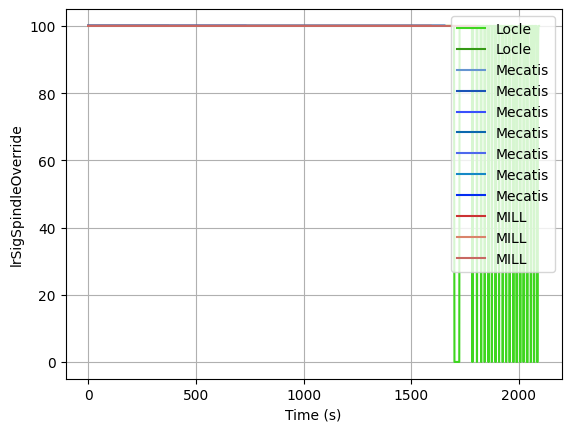

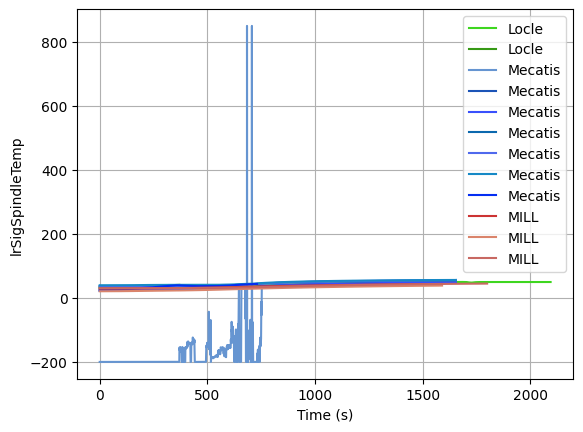

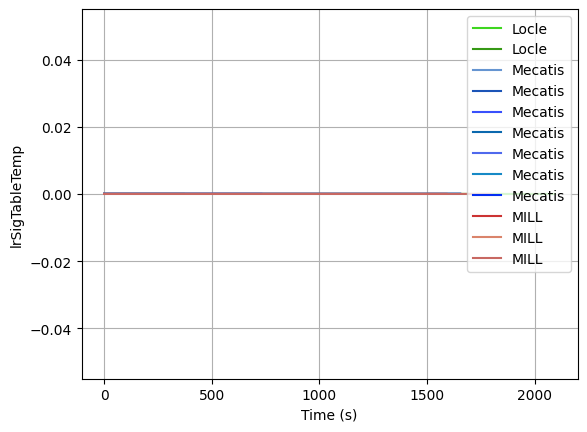

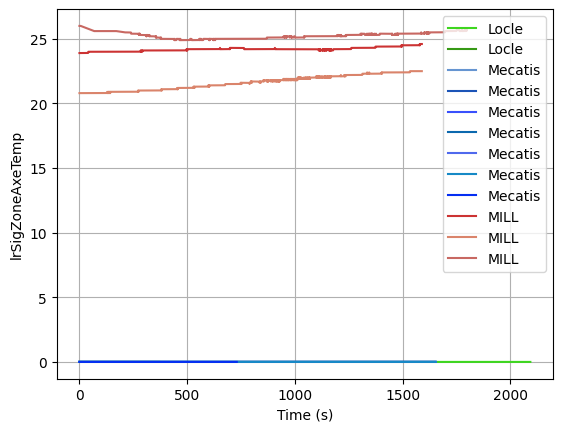

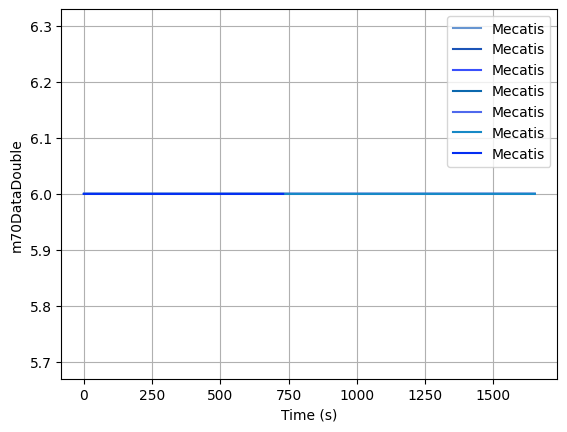

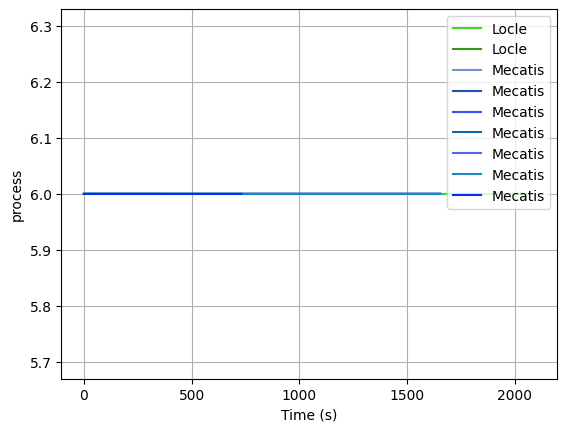

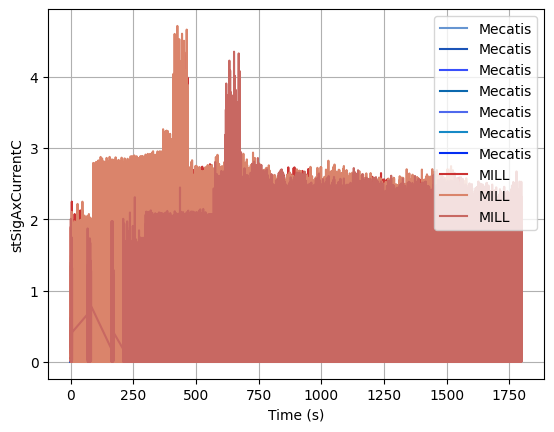

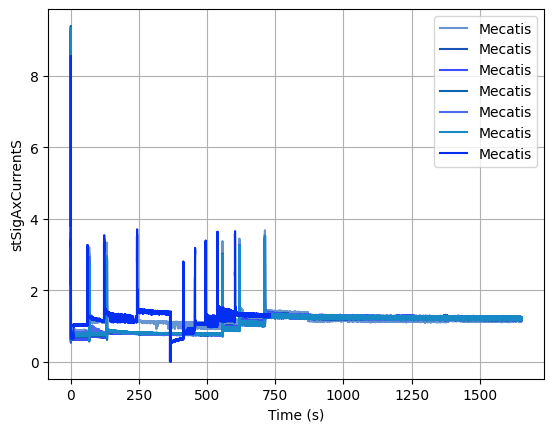

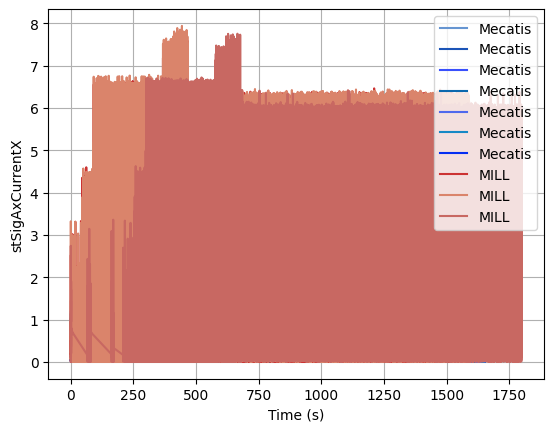

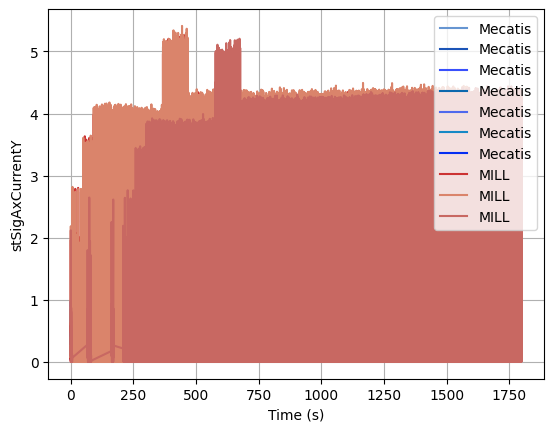

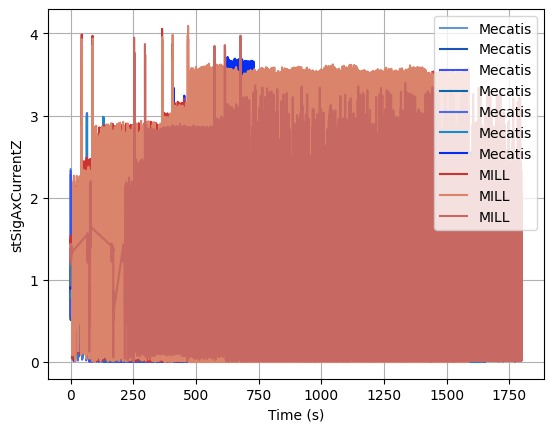

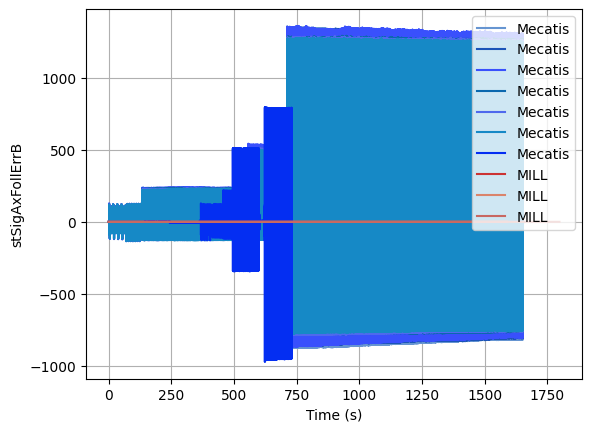

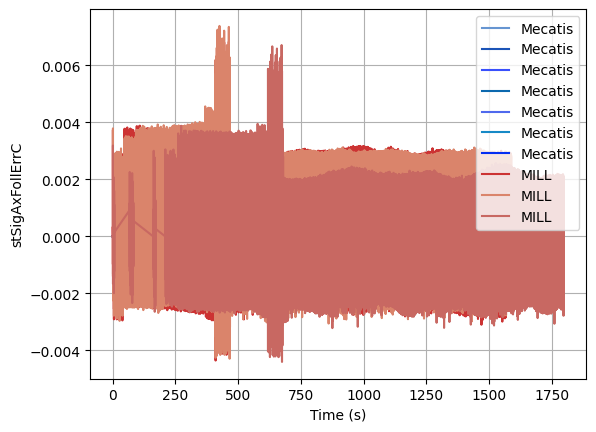

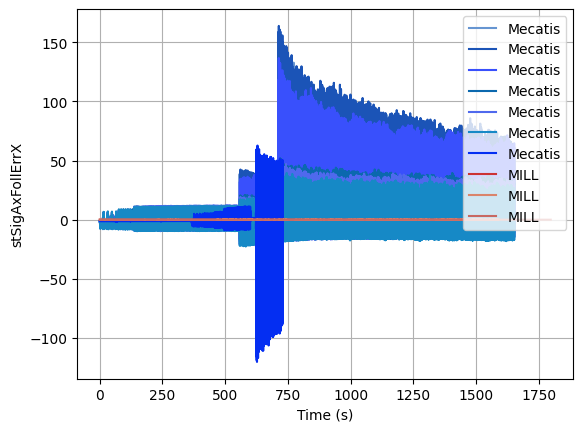

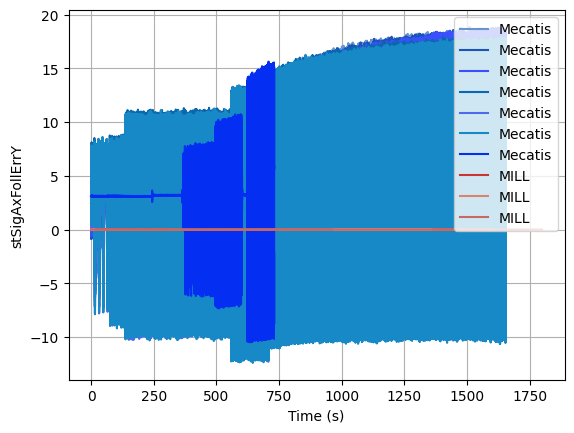

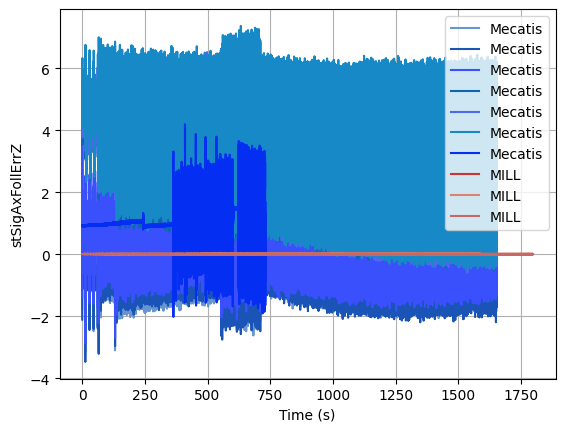

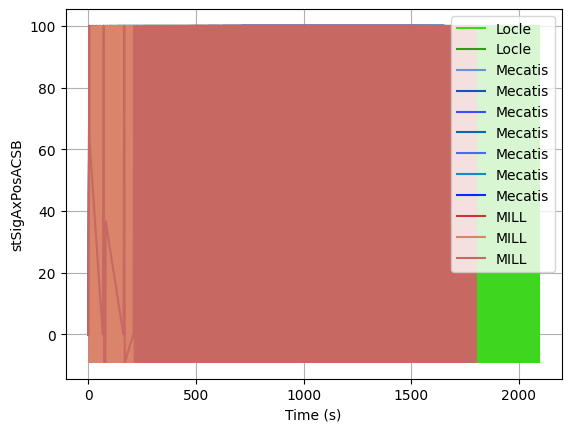

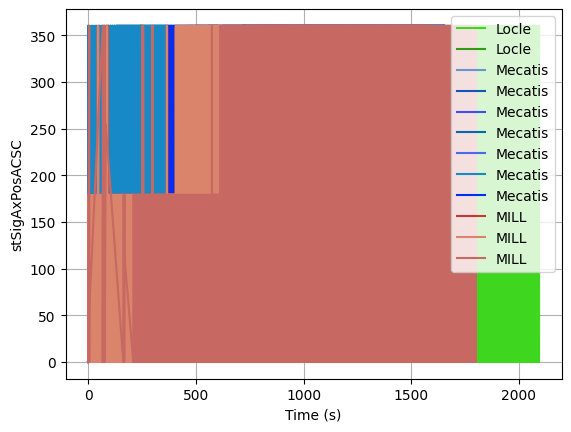

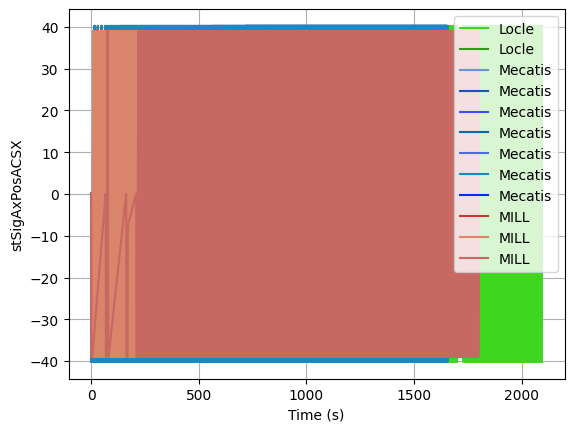

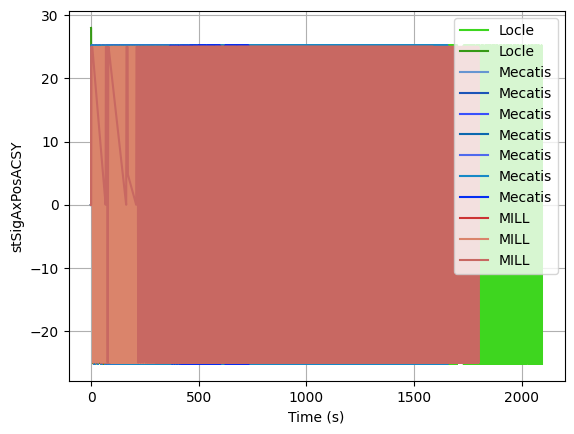

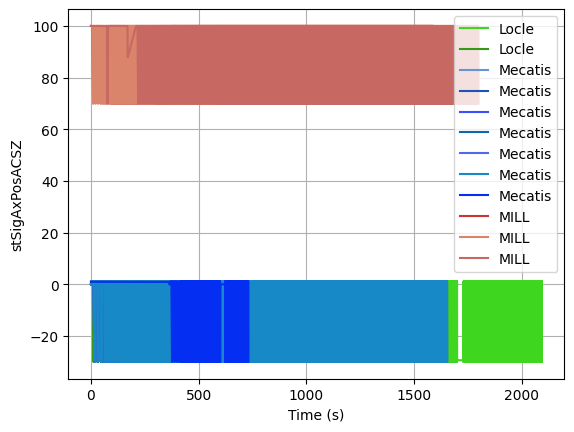

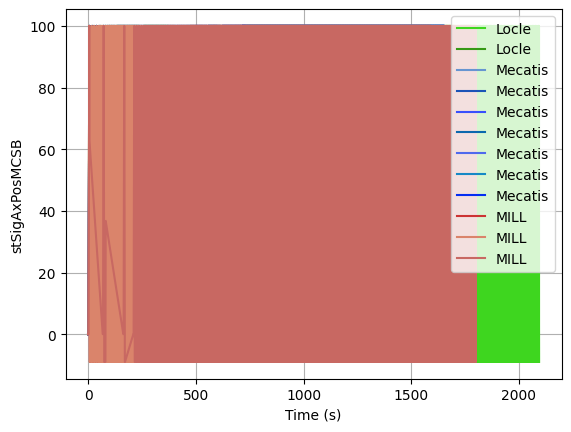

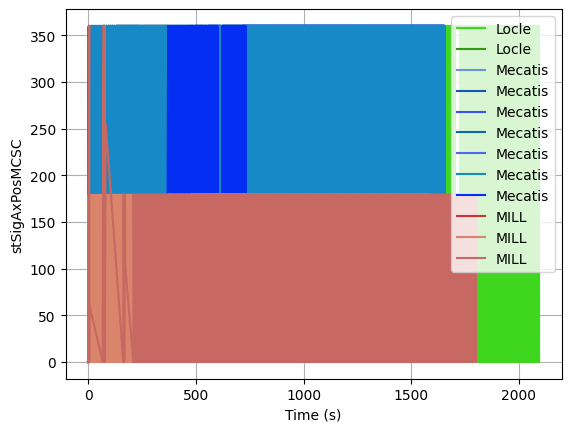

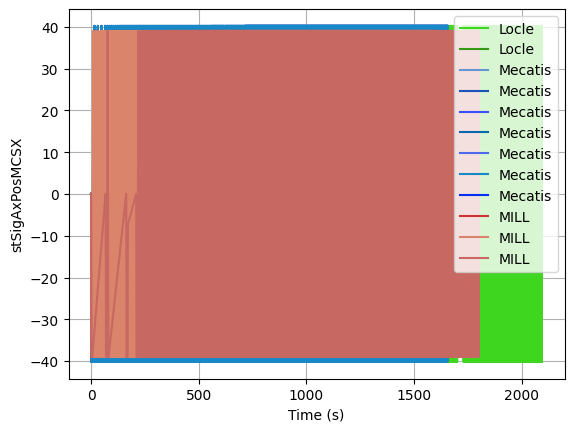

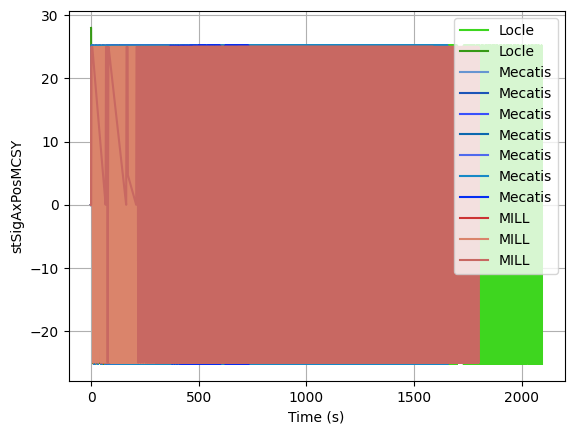

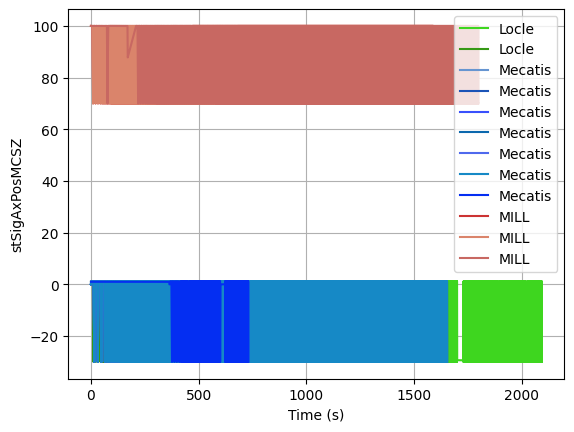

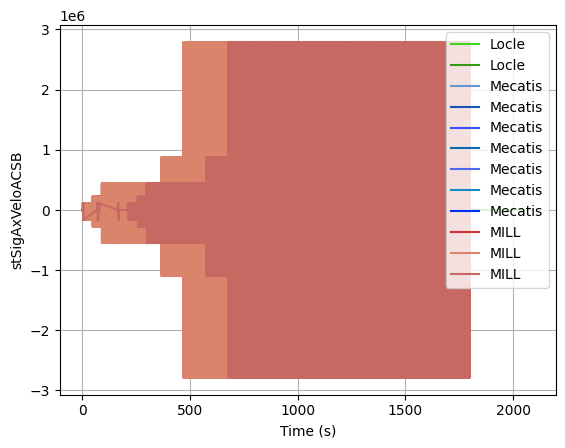

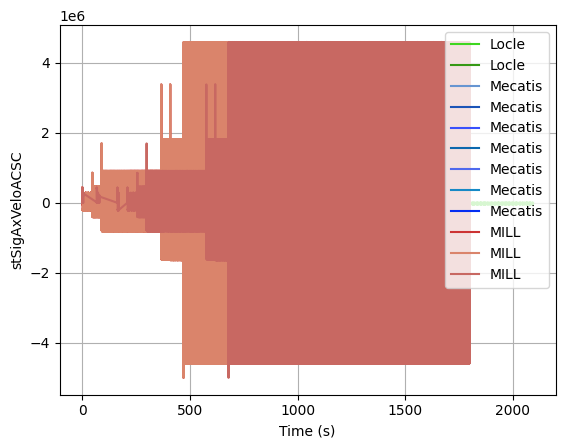

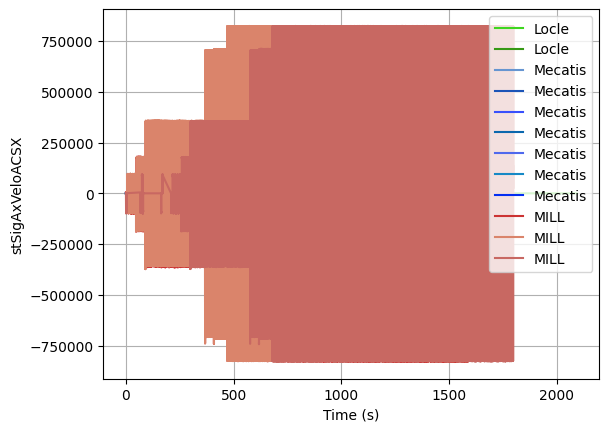

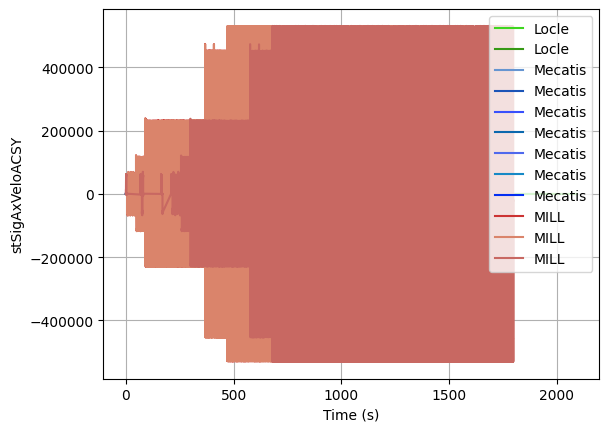

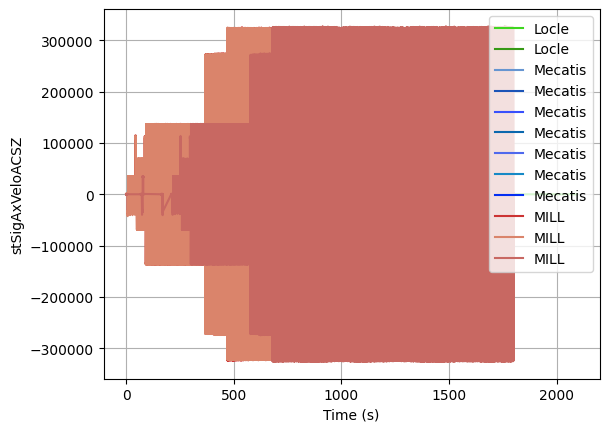

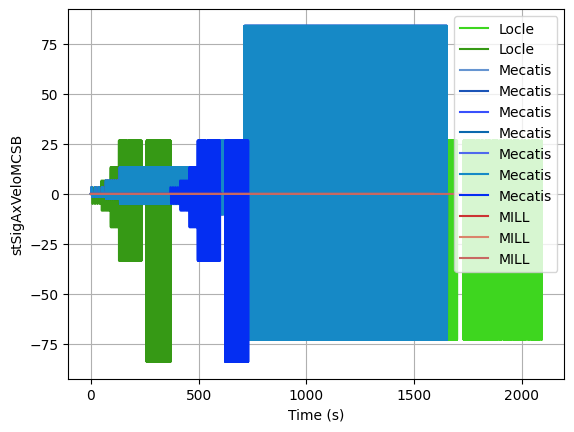

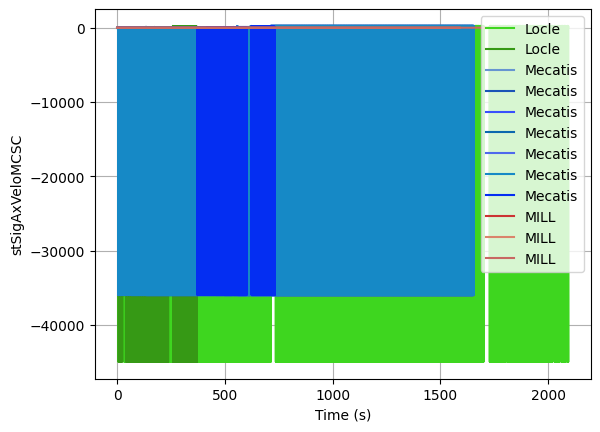

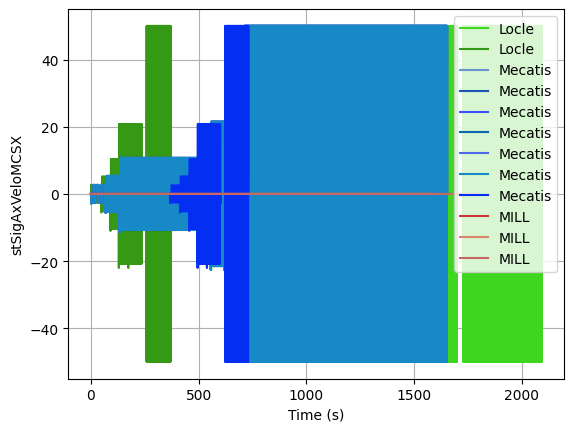

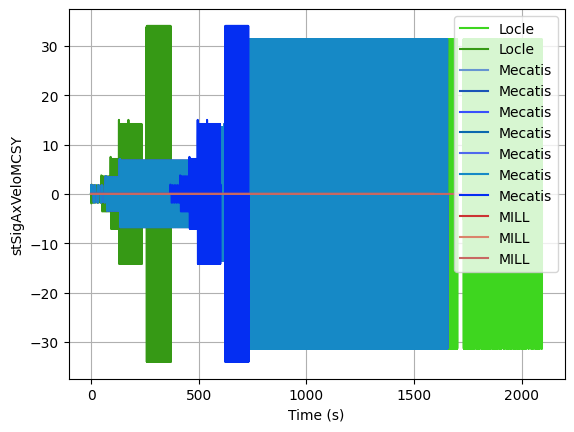

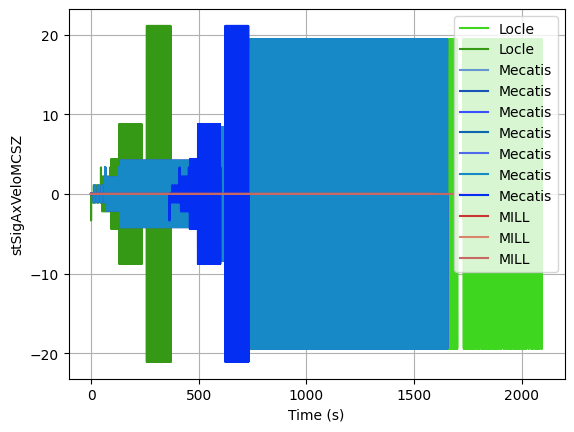

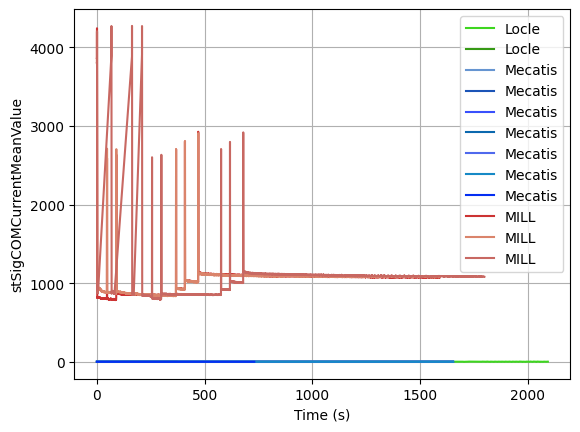

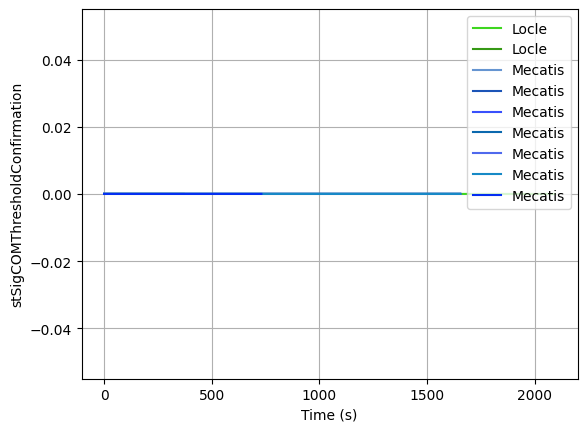

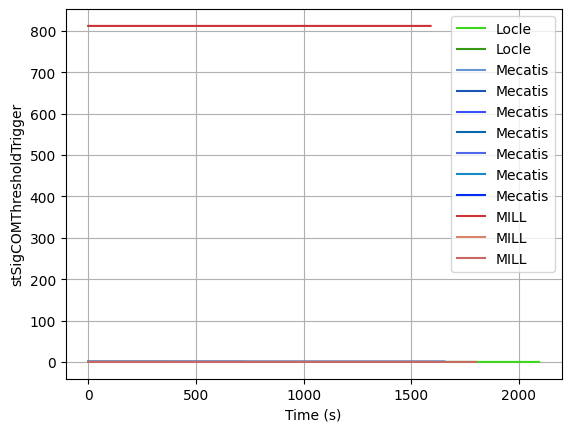

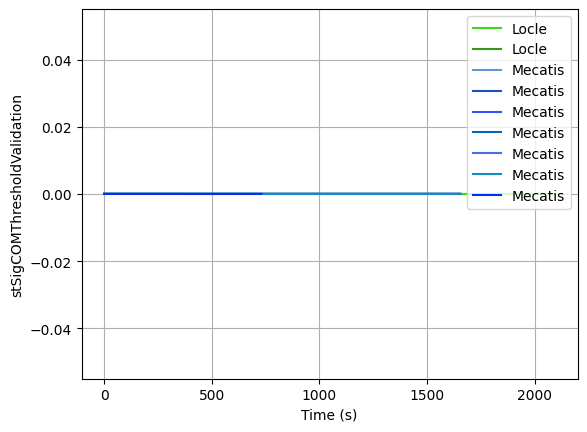

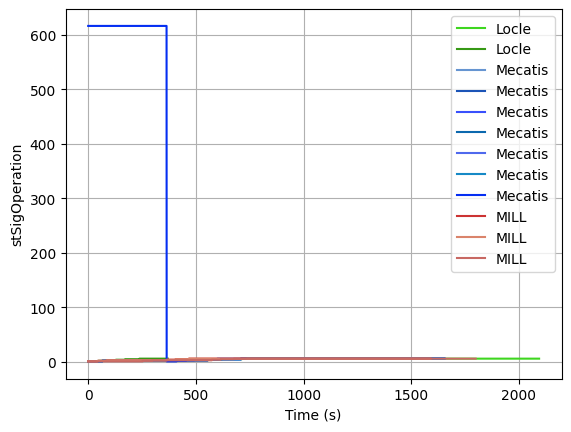

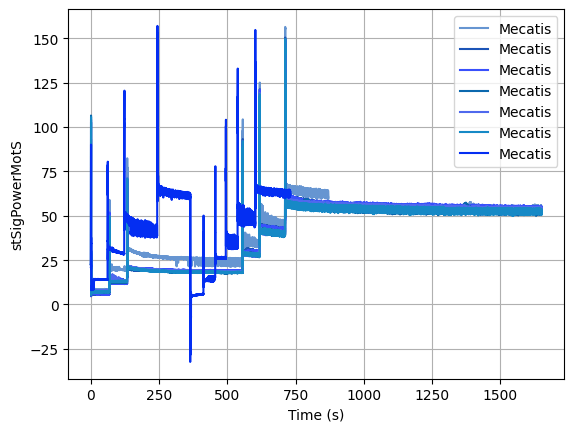

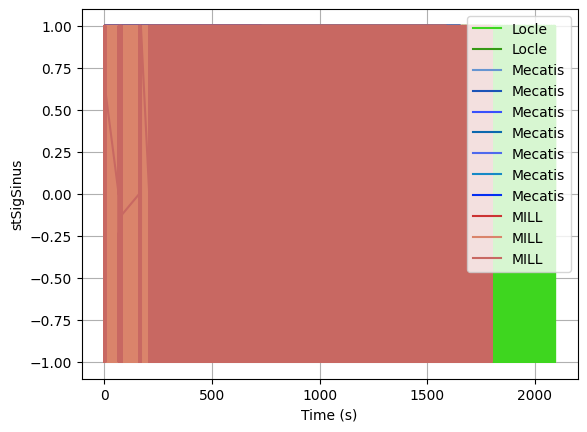

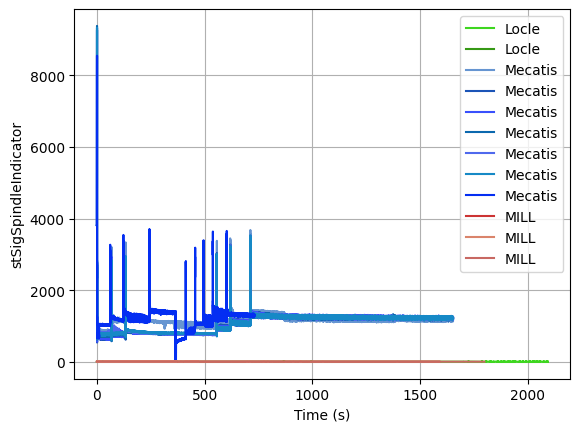

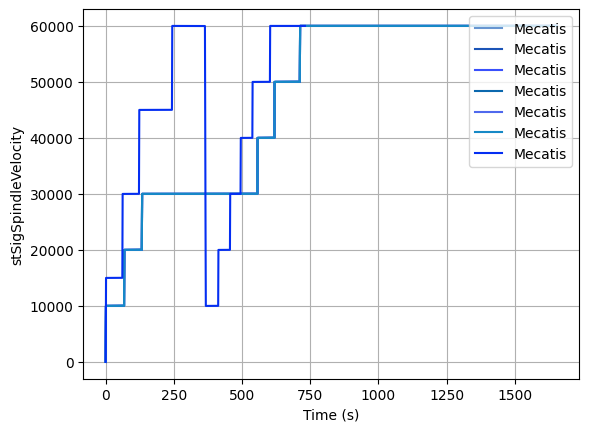

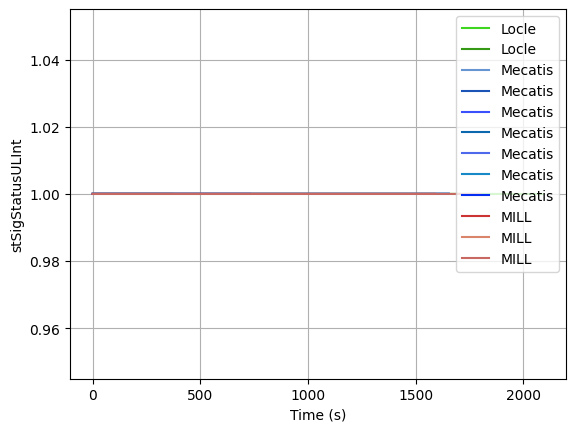

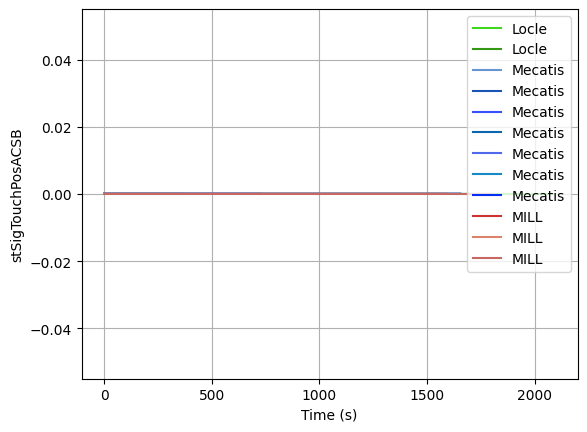

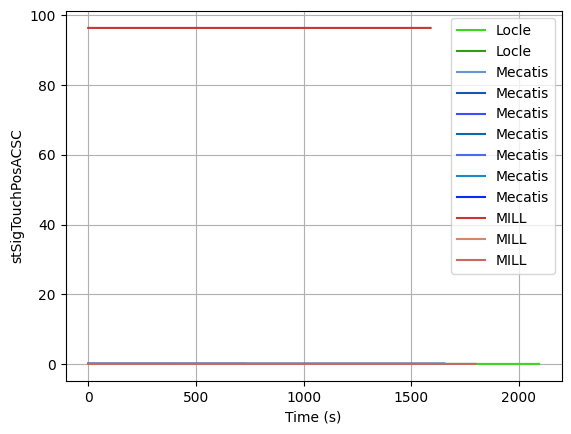

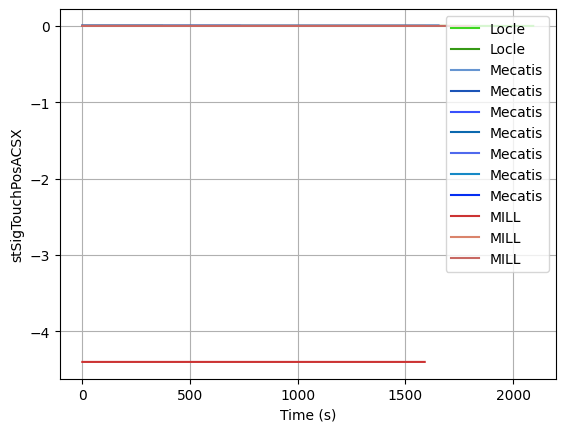

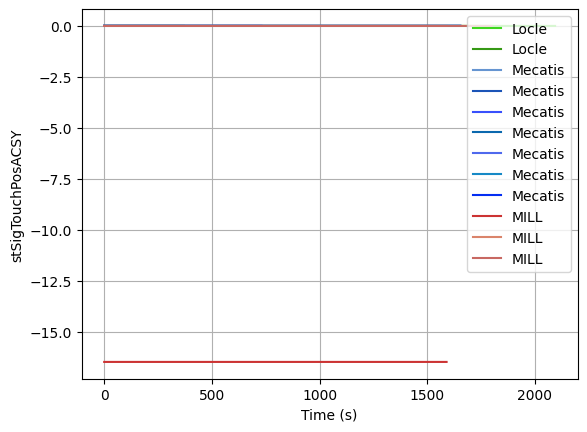

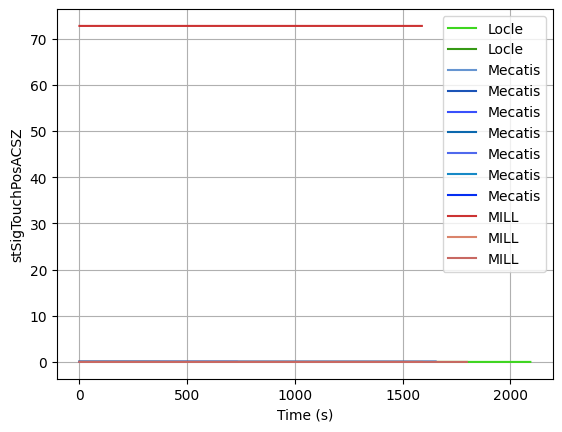

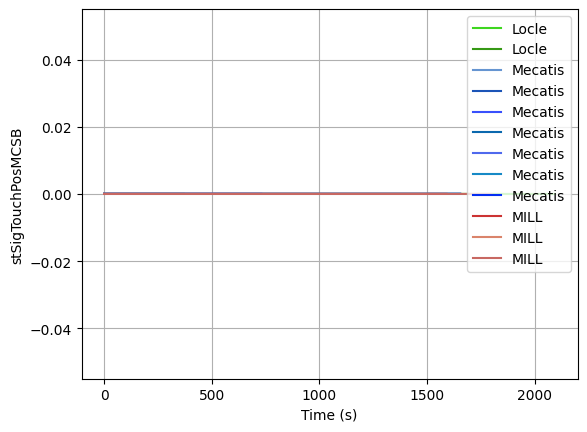

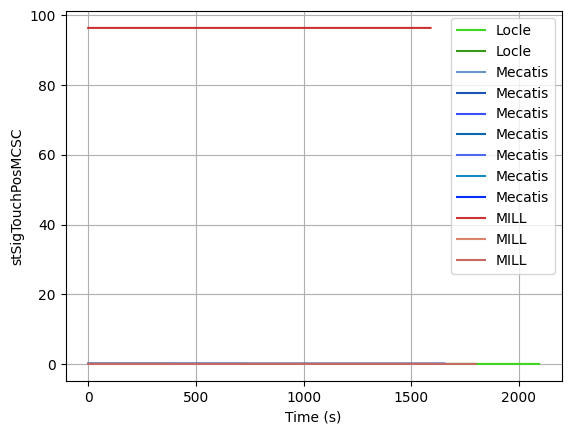

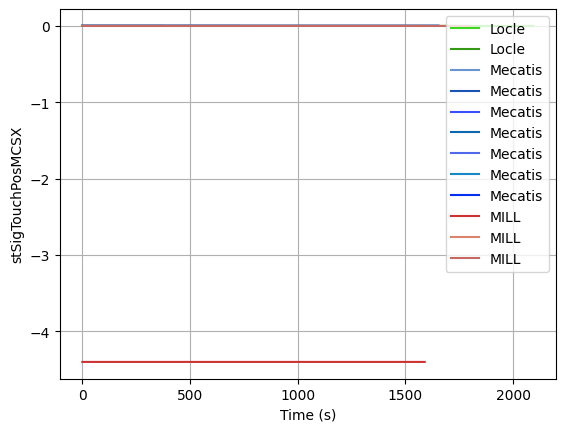

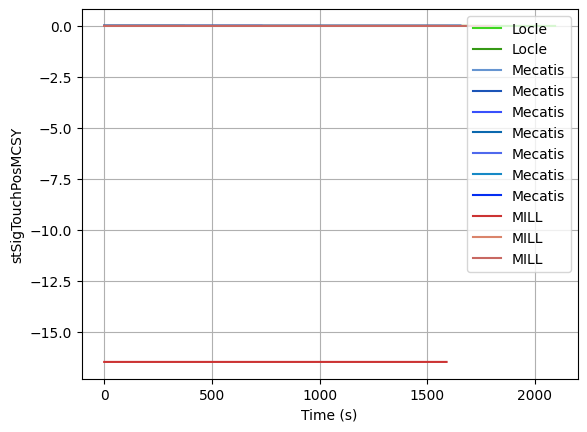

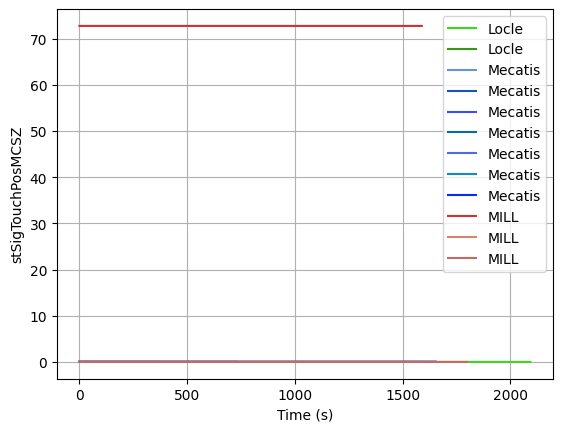

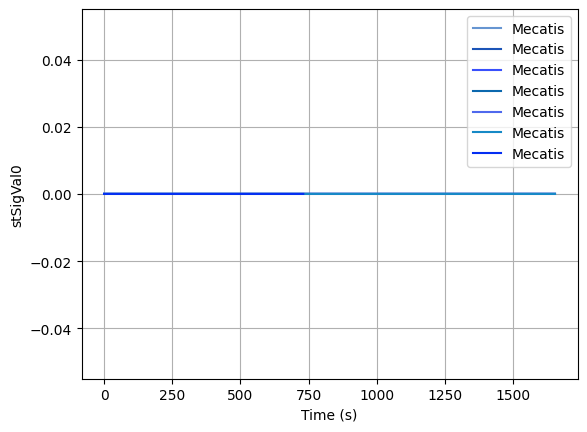

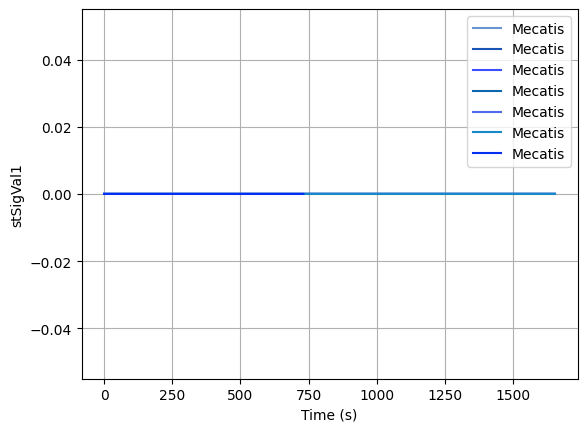

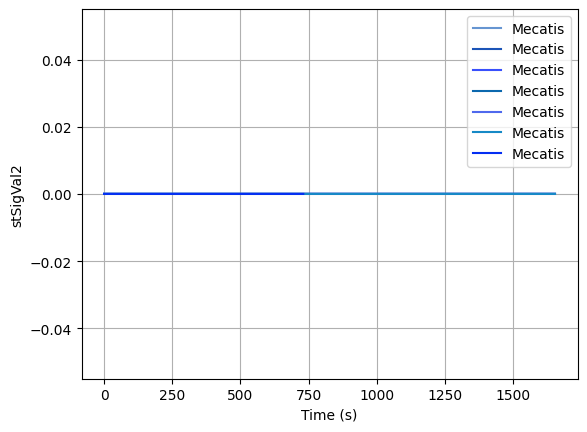

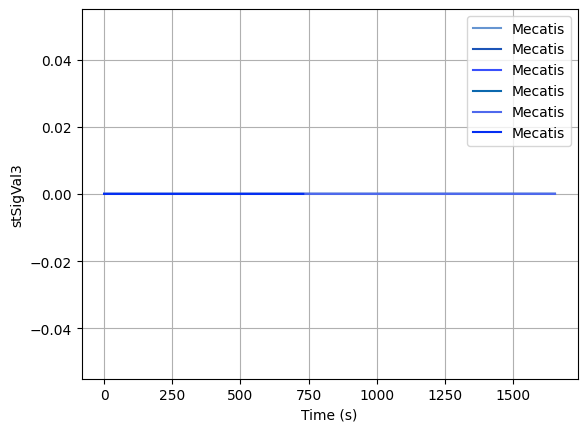

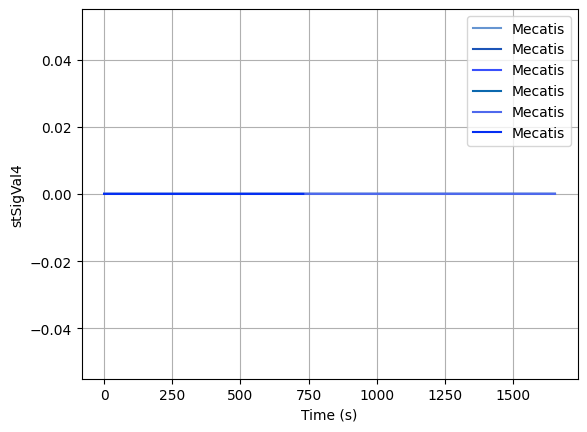

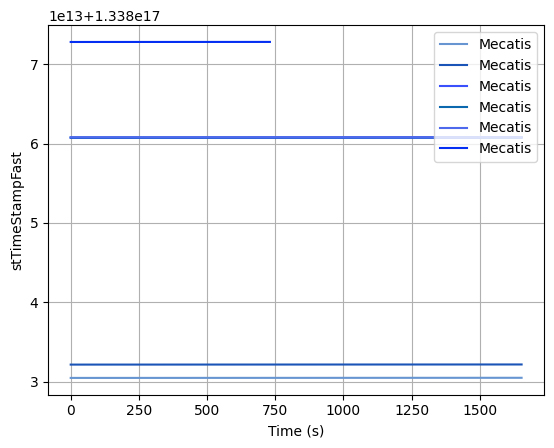

In [86]:
max_time_index = 50000000
filtered_data = [data_prepared[1]] + [data_prepared[8]] 

for signal in signals :
    plot_signal(data_prepared, signal, max_time_index)